In [1]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from utils import read_data, int_enc, shuffle_Xy, plot_confusion_matrix, plot_roc_curves
import matplotlib.pyplot as plt
import numpy as np

#### Run config

In [2]:
lr_model = Pipeline([
    ("pca", PCA(n_components=50)),
    ("lr", LogisticRegression(max_iter=50000))
])
nn_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50))

configs = {
    "LR on GPL96": {
        "genes": "GPL96", 
        "model": lr_model,
        "cv_results": None
    },
    "NN on GPL96": {
        "genes": "GPL96", 
        "model": nn_model,
        "cv_results": None
    },
    "LR on GPL570": {
        "genes": "GPL570", 
        "model": lr_model,
        "cv_results": None
    },
    "NN on GPL570": {
        "genes": "GPL570", 
        "model": nn_model,
        "cv_results": None
    }
}

In [3]:
for name, config in configs.items():

    # extract the params
    genes = config["genes"]
    model = config["model"]
    prefix = name.replace(" ", "")

    # prepare the dataset
    data = read_data(f"data/{genes}Restriction.csv")
    data, labels = int_enc(data)

    X = data.drop(["label"], axis=1).values
    y = data["label"].values

    X = StandardScaler().fit_transform(X)
    X, y = shuffle_Xy(X, y)

    # perform ten fold cross val.
    cv = cross_validate(model, X, y, cv=10)
    config["cv_results"] = cv["test_score"]

    # train and predict on a test set
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.30)

    model.fit(X_tr, y_tr)
    yhat = model.predict(X_te)
    yhat_proba = model.predict_proba(X_te)

    # plot the confusion matrix
    plot_confusion_matrix(
        y_te, 
        yhat,
        labels,
        title=f"{name} - Confusion Matrix",
        path=f"results/{prefix}Confusion.png"
    )

    # plot the roc curves
    plot_roc_curves(
        y_te, 
        yhat_proba,
        labels, 
        title=f"{name} - ROC Curve", 
        path=f"results/{prefix}ROC.png"
    )

#### Visualize the Acc. Distribution

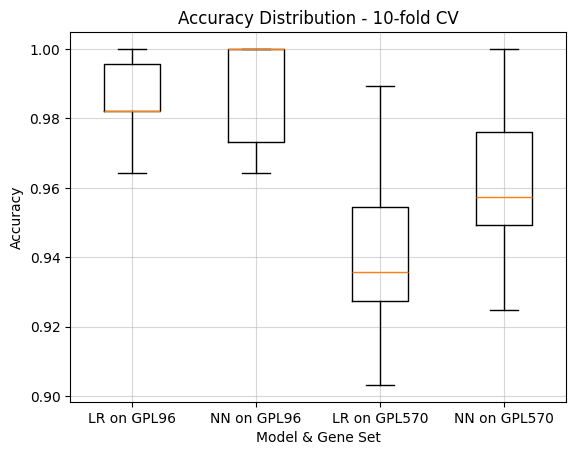

In [4]:
plt.title("Accuracy Distribution - 10-fold CV")
plt.boxplot(
    [ c["cv_results"] for c in configs.values() ],
    labels=list(configs.keys())
)
plt.xlabel("Model & Gene Set")
plt.ylabel("Accuracy")
plt.grid(alpha=.5)

plt.savefig("results/AccuracyDist.png")
plt.show()